In [1]:
%pip install tensorflow-gpu==2.10.0


Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np

# Load and preprocess the dataset
def load_dataset(directory, image_size=(256, 256), batch_size=32):
    return image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size
    )

# Preprocess function: Normalize the images
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image
    return image, label

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Create a custom model using the EfficientNetV2 from tf.keras.applications
def create_model(num_classes):
    efficientnet = EfficientNetV2B0(include_top=False, input_shape=(256, 256, 3))
    x = GlobalAveragePooling2D()(efficientnet.output)
    x = Dropout(0.25)(x)  # Add dropout layer
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=efficientnet.input, outputs=output)
    return model

# Function to compile and train the model
def train_model(model, train_dataset, test_dataset, epochs=25):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    labels = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, class_weight=class_weights_dict)
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f'Test accuracy: {test_acc * 100:.2f}%')

    # Save the entire model
    model.save('EfficientNet_skin_disease_classifier_model.h5')  # Save the model with .h5 extension
    print("Model saved as EfficientNet_skin_disease_classifier_model.h5")

    return history, model 

# Main function to run the training and testing process
def main():
    train_dir = 'train_set'
    test_dir = 'test_set'

    # Load datasets with preprocessing and augmentation
    train_dataset = load_dataset(train_dir).map(lambda x, y: (data_augmentation(x), y)).map(preprocess_image).shuffle(1000)
    test_dataset = load_dataset(test_dir).map(preprocess_image)

    model = create_model(num_classes=8)
    history, trained_model = train_model(model, train_dataset, test_dataset)

    return history, trained_model, test_dataset

# Run the main function
history, model, test_dataset = main()


Found 924 files belonging to 8 classes.
Found 233 files belonging to 8 classes.
Epoch 1/25
29/29 [==============================] - 14s 268ms/step - loss: 1.8553 - accuracy: 0.3290 - val_loss: 2.1089 - val_accuracy: 0.0987
Epoch 2/25
29/29 [==============================] - 8s 270ms/step - loss: 1.2594 - accuracy: 0.7284 - val_loss: 1.9202 - val_accuracy: 0.2446
Epoch 3/25
29/29 [==============================] - 8s 268ms/step - loss: 0.8105 - accuracy: 0.8463 - val_loss: 1.1283 - val_accuracy: 0.6695
Epoch 4/25
29/29 [==============================] - 8s 267ms/step - loss: 0.5148 - accuracy: 0.8918 - val_loss: 1.3470 - val_accuracy: 0.5322
Epoch 5/25
29/29 [==============================] - 8s 267ms/step - loss: 0.3303 - accuracy: 0.9513 - val_loss: 1.2193 - val_accuracy: 0.6438
Epoch 6/25
29/29 [==============================] - 8s 263ms/step - loss: 0.2293 - accuracy: 0.9621 - val_loss: 0.7291 - val_accuracy: 0.7811
Epoch 7/25
29/29 [==============================] - 8s 266ms/step -

1/1 [==============================] - 1s 835ms/step


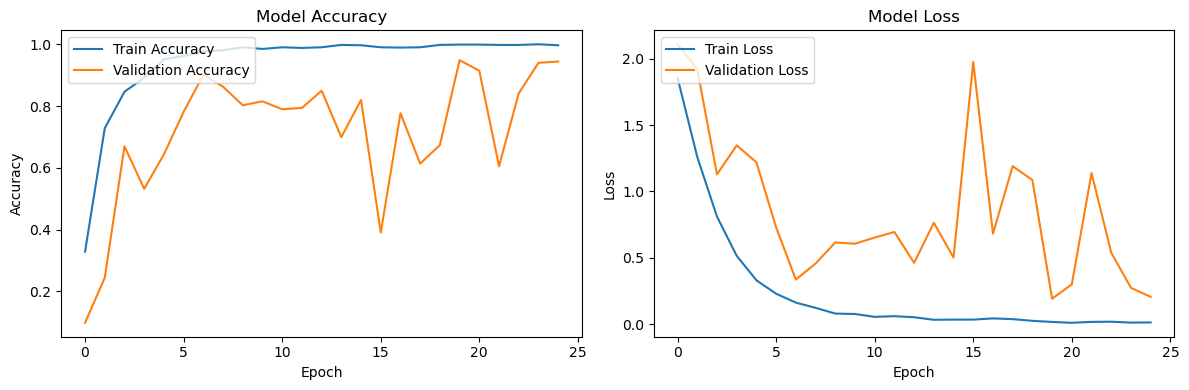

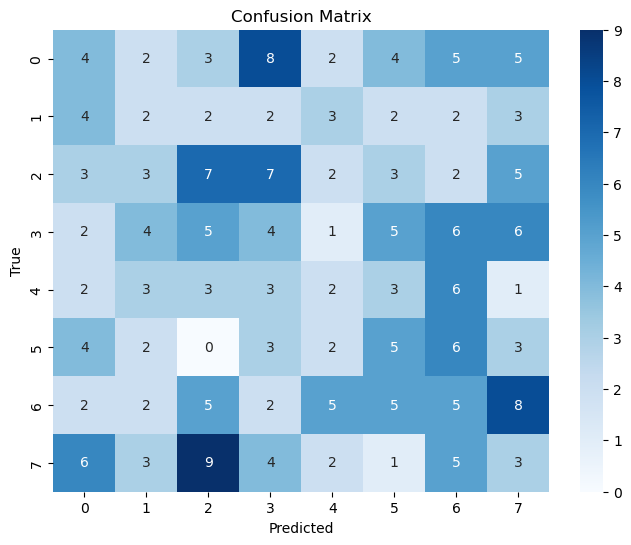

              precision    recall  f1-score   support

           0       0.15      0.12      0.13        33
           1       0.10      0.10      0.10        20
           2       0.21      0.22      0.21        32
           3       0.12      0.12      0.12        33
           4       0.11      0.09      0.10        23
           5       0.18      0.20      0.19        25
           6       0.14      0.15      0.14        34
           7       0.09      0.09      0.09        33

    accuracy                           0.14       233
   macro avg       0.13      0.14      0.13       233
weighted avg       0.14      0.14      0.14       233



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Get true and predicted labels
def get_predictions(test_dataset, model):
    y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
    y_pred = []

    for images, _ in test_dataset:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=-1))

    return y_true, np.array(y_pred)

# Load the saved model
model_path = 'EfficientNet_skin_disease_classifier_model.h5'
model = load_model(model_path)

# Assuming you have `test_dataset` and `history` from the previous steps
# Get predictions and plot results
y_true, y_pred = get_predictions(test_dataset, model)
plot_training_history(history)
plot_confusion_matrix(y_true, y_pred)

# Print classification report
print(classification_report(y_true, y_pred))
